## Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pandas.plotting import scatter_matrix
%matplotlib inline

---
# Time Penalization/Score

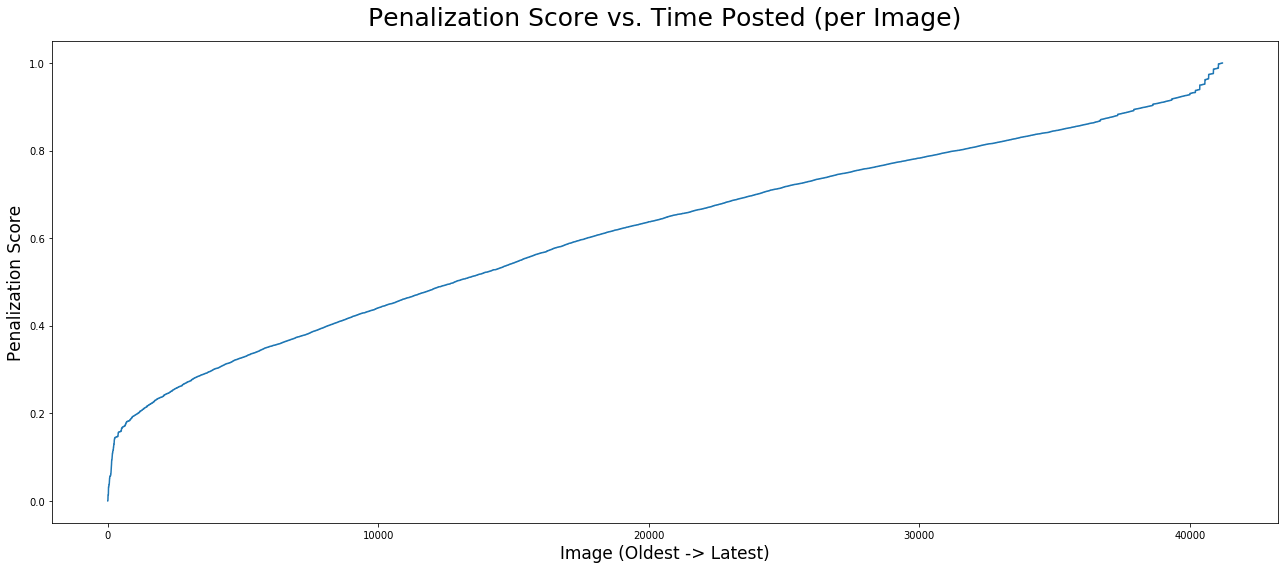

In [3]:
image_df = pd.read_pickle(r'imagedata_total.pickle')
image_df['time_dt'] = pd.to_datetime(image_df['image_posted_time'])
image_df['elapsed_time'] = (datetime.date(2017, 12, 6) - image_df['time_dt'].dt.date).dt.days
image_df['time_score'] = 1 - (image_df['elapsed_time'] / max(image_df['elapsed_time']))
ordered_elapsed = image_df.sort_values('time_dt', ascending=True)[['time_score', 'time_dt']]
dates = list(ordered_elapsed['time_dt'])
dates

fig = plt.figure(figsize=(18,8))
plt.plot(list(ordered_elapsed['time_score']))
plt.title('Penalization Score vs. Time Posted (per Image)', fontsize=25, y=1.02)
plt.xlabel('Image (Oldest -> Latest)', size=17)
plt.ylabel('Penalization Score', size=17)
plt.tight_layout()
plt.savefig('penalization_score_time.eps', format='eps', dpi=900)
plt.show();

## Time Score Distribution

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


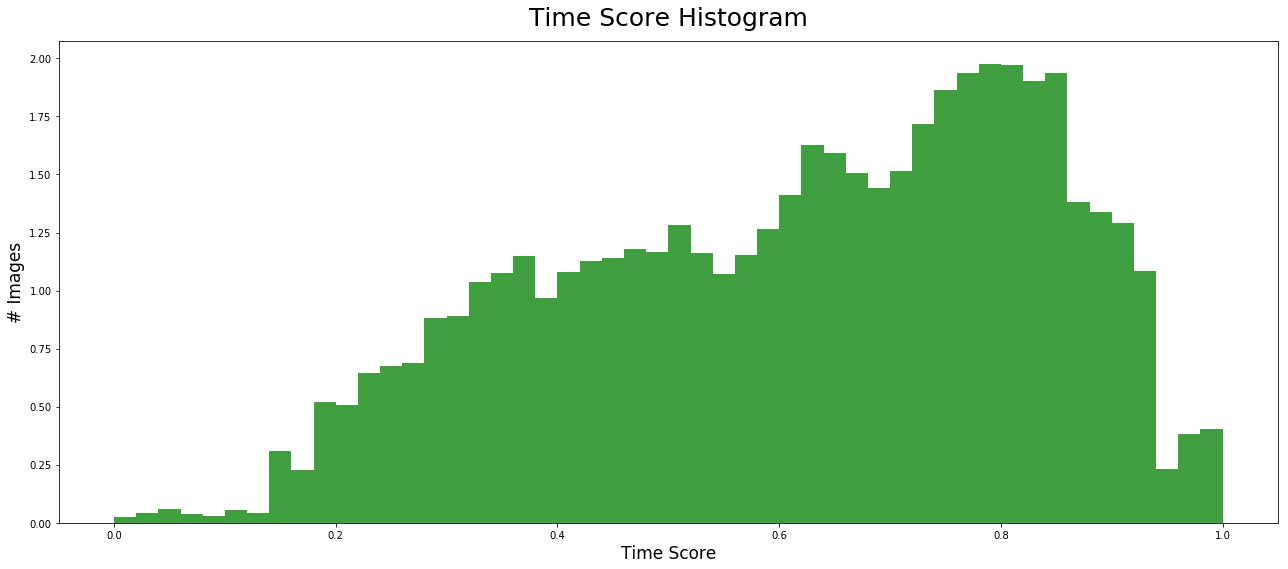

In [4]:
fig = plt.figure(figsize=(18,8))
mu, sigma = 100, 15

# the histogram of the data
n, bins, patches = plt.hist(image_df['time_score'], 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.title('Time Score Histogram', fontsize=25, y=1.02)
plt.xlabel('Time Score', size=17)
plt.ylabel('# Images', size=17)
plt.tight_layout()
plt.savefig('time_score_hist.eps', format='eps', dpi=900)
plt.show();

---
# Time-scored image dataframe (FINAL DATA)

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
image_df_numeric = image_df.select_dtypes(include=numerics)

# Multiply each image_id vector by the corresponding time_score to get image_scored
image_scored = image_df_numeric.loc[:, image_df_numeric.columns != 'time_score'].multiply(image_df_numeric["time_score"], axis="index")

image_scored['image_id'] = image_df['image_id']
image_scored['user_id'] = image_df['user_id']

# Get sum of scores per user
image_df_numeric['user_id'] = image_df['user_id'] # Add user_id for aggregations by user
sum_scores_by_user = image_df_numeric[['user_id', 'time_score']].groupby('user_id').sum()

# Aggregate data by user: First sum all image_data per user and then divide by the sum of scores for that user (i.e. weighted average).
imagedata_aggr = image_scored.groupby('user_id').sum()
imagedata_aggr = imagedata_aggr.divide(sum_scores_by_user["time_score"], axis="index")

imagedata_aggr.to_pickle("scored_image_data.pickle")

print(imagedata_aggr.shape)
imagedata_aggr.head()

(159, 47)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,age,glasses,face_emotion_ANGRY,face_emotion_CALM,...,emotion_label_loathing,emotion_label_pensiveness,emotion_label_rage,emotion_label_sadness,emotion_label_serenity,emotion_label_surprise,emotion_label_terror,emotion_label_trust,emotion_label_vigilance,elapsed_time
user_id,,,,,,,,,,,,,,,,,,,,,
1097967773,637.970690,632.093248,0.841787,53.0,154.0,282.0,3.284598,0.053156,0.068223,0.026541,...,0.000000,0.000666,0.000868,0.170934,0.016352,0.006234,0.004035,0.004600,0.000000,687.633202
11520833,619.577852,619.599502,0.825129,201.0,299.0,312.0,10.163108,0.078891,0.047685,0.025500,...,0.000353,0.000696,0.015459,0.124499,0.018922,0.012713,0.018959,0.016754,0.000353,1220.942419
1223036636,640.000000,640.000000,0.869296,169.0,159.0,48.0,10.646955,0.049008,0.043948,0.015778,...,0.000000,0.000000,0.007985,0.096364,0.011702,0.011712,0.000000,0.027301,0.000000,1180.661228
1224423305,433.454092,594.387356,0.790564,1.0,18.0,41.0,1.399039,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005182,0.060168,0.034620,0.004828,0.015310,0.004830,0.000000,332.950077
1249457735,646.648337,640.000000,0.802397,66.0,93.0,30.0,5.259787,0.006386,0.046706,0.035554,...,0.000000,0.000000,0.000000,0.145421,0.027053,0.000000,0.007524,0.024916,0.000000,721.457422
